# Deep Feedforward Neural Network (DFNN) from Scratch — Binary Classification

**Objective:** Build and train a deep feedforward neural network **entirely with NumPy** for a non-linear binary classification task, then visualize:
1) the dataset
2) the training **loss curve**
3) the **decision boundary**.

**What’s inside**
- Activation functions (**Sigmoid**, **ReLU**, **Tanh**) and their **derivatives**
- **Binary Cross-Entropy (BCE)** loss with numerical stability
- `DeepNeuralNetwork` class: initialization (He/Xavier), **forward**, **backward**, **update**, **train**, **predict**
- Two-moons dataset generator (NumPy; with optional sklearn if available)
- Plots: dataset scatter, training loss, decision boundary
- **Discussion** of performance, loss trend, activations/init, and challenges


In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)


## Activation Functions & Derivatives

We implement the following activation functions and their derivatives:

### **1. Sigmoid**

* Function:

  $$
  \sigma(z) = \frac{1}{1 + e^{-z}}
  $$
* Derivative:

  $$
  \sigma'(z) = \sigma(z) \cdot (1 - \sigma(z))
  $$

 We cache **A** (the output of sigmoid) to compute the derivative efficiently.

---

### **2. ReLU (Rectified Linear Unit)**

* Function:

  $$
  \text{ReLU}(z) = \max(0, z)
  $$
* Derivative:

  $$
  \text{ReLU}'(z) = \begin{cases}
    1 & \text{if } z > 0 \\
    0 & \text{if } z \leq 0
  \end{cases}
  $$

 We cache **Z** (the input to ReLU) to compute the derivative.

---

### **3. Tanh**

* Function:

  $$
  \tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
  $$
* Derivative:

  $$
  \tanh'(z) = 1 - \tanh^2(z)
  $$

 We cache **A** (the output of tanh) to compute the derivative efficiently.

---

### Summary of What We Cache:

| Activation | Cached Value | Purpose        |
| ---------- | ------------ | -------------- |
| Sigmoid    | A            | For derivative |
| ReLU       | Z            | For derivative |
| Tanh       | A            | For derivative |

---



In [50]:
def sigmoid(z):
    # Clip for numerical stability in exp
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def dsigmoid_from_a(a):
    # a = sigmoid(z)
    return a * (1.0 - a)

def relu(z):
    return np.maximum(0.0, z)

def drelu_from_z(z):
    return (z > 0).astype(z.dtype)

def tanh(z):
    return np.tanh(z)

def dtanh_from_a(a):
    # a = tanh(z)
    return 1.0 - a**2



## Part 1 — Loss Function: Binary Cross-Entropy (BCE)

The **Binary Cross-Entropy** loss is defined as:

$$
\mathcal{L}(\hat{y}, y) = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

We also provide the derivative with respect to the prediction **A** (i.e., \$\frac{\partial \mathcal{L}}{\partial A}\$) for completeness.

 For the **BCE + Sigmoid** combination, the gradient at the output layer simplifies to:

$$
dZ = A - y
$$

This is because the derivative of the loss and the derivative of the sigmoid activation combine neatly during backpropagation.



In [51]:
def binary_cross_entropy(a_hat, y, eps=1e-12):
    """
    a_hat, y shapes: (1, m)
    """
    a_hat = np.clip(a_hat, eps, 1.0 - eps)
    m = y.shape[1]
    return -np.sum(y * np.log(a_hat) + (1 - y) * np.log(1 - a_hat)) / m

def dloss_da(a_hat, y, eps=1e-12):
    # Not used at the output when combining BCE+sigmoid (we use dZ = A - y),
    # but provided for completeness.
    a_hat = np.clip(a_hat, eps, 1.0 - eps)
    return -(y / a_hat) + ((1 - y) / (1 - a_hat))


## Part 2 — Deep Neural Network Class

### **1. Initialization**

* Use **He initialization** for layers with ReLU activation.
* Use **Xavier/Glorot initialization** for layers with Sigmoid or Tanh.
* This helps **prevent vanishing/exploding gradients** and ensures smoother gradient flow.

---

### **2. Forward Propagation**

For each layer $l = 1, 2, \dots, L$:

* Linear step:

  $$
  Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}
  $$
* Activation step:

  $$
  A^{[l]} = \text{activation}(Z^{[l]})
  $$

---

### **3. Backward Propagation**

* Start at the output layer with **Binary Cross-Entropy + Sigmoid**:

  $$
  dZ^{[L]} = A^{[L]} - y
  $$
* Then, propagate gradients backward using the **chain rule** through each layer:

  * Compute $dW^{[l]}$, $db^{[l]}$, and $dA^{[l-1]}$ from $dZ^{[l]}$
  * For hidden layers:

    $$
    dZ^{[l]} = dA^{[l]} \circ g'^{[l]}(Z^{[l]})
    $$

---

### **4. Parameter Update**

Using **gradient descent**, update the weights and biases:

$$
W^{[l]} \leftarrow W^{[l]} - \alpha \, dW^{[l]}
$$

$$
b^{[l]} \leftarrow b^{[l]} - \alpha \, db^{[l]}
$$

Where $\alpha$ is the learning rate.

---

### **5. Matrix Shapes**

We adopt **column-major format** (samples as columns):

* Input:

  $$
  X \in \mathbb{R}^{n \times m}
  $$
* Labels:

  $$
  y \in \mathbb{R}^{1 \times m}
  $$
* Each layer:

  * $A^{[l]} \in \mathbb{R}^{n_l \times m}$
  * $W^{[l]} \in \mathbb{R}^{n_l \times n_{l-1}}$
  * $b^{[l]} \in \mathbb{R}^{n_l \times 1}$



In [52]:
class DeepNeuralNetwork:
    def __init__(self, layer_dims, activation_funcs):
        """
        layer_dims: list of layer sizes, e.g. [2, 20, 10, 1]
        activation_funcs: list of str per layer (hidden+output), length = len(layer_dims)-1
                          each in {'relu','sigmoid','tanh'}
        """
        assert len(activation_funcs) == len(layer_dims) - 1, \
            "activation_funcs length must be len(layer_dims)-1"
        self.layer_dims = layer_dims
        self.activation_funcs = [a.lower() for a in activation_funcs]
        self.params = {}

        L = len(layer_dims) - 1
        for l in range(1, L + 1):
            n_in, n_out = layer_dims[l - 1], layer_dims[l]
            act = self.activation_funcs[l - 1]
            # Init: He for ReLU; Xavier for sigmoid/tanh
            if act == 'relu':
                W = np.random.randn(n_out, n_in) * np.sqrt(2.0 / n_in)
            else:
                W = np.random.randn(n_out, n_in) * np.sqrt(1.0 / n_in)
            b = np.zeros((n_out, 1))
            self.params[f"W{l}"] = W
            self.params[f"b{l}"] = b

    def _activate(self, Z, act):
        if act == 'relu':
            A = relu(Z); cache = ('relu', Z)       # cache Z for derivative
        elif act == 'sigmoid':
            A = sigmoid(Z); cache = ('sigmoid', A) # cache A for derivative
        elif act == 'tanh':
            A = tanh(Z); cache = ('tanh', A)       # cache A for derivative
        else:
            raise ValueError(f"Unknown activation: {act}")
        return A, cache

    def _activate_backward(self, dA, cache):
        kind, val = cache
        if kind == 'relu':
            return dA * drelu_from_z(val)      # val = Z
        elif kind == 'sigmoid':
            return dA * dsigmoid_from_a(val)   # val = A
        elif kind == 'tanh':
            return dA * dtanh_from_a(val)      # val = A
        else:
            raise ValueError(f"Unknown activation cache: {kind}")

    def forward_pass(self, X):
        """
        X shape: (n_features, m). Returns (A_L, caches)
        caches contains: A[0..L], Z[1..L], act_cache[1..L]
        """
        caches = {"A": {}, "Z": {}, "act_cache": {}}
        A = X
        caches["A"][0] = A
        L = len(self.layer_dims) - 1
        for l in range(1, L + 1):
            W = self.params[f"W{l}"]; b = self.params[f"b{l}"]
            Z = W @ A + b
            A, act_cache = self._activate(Z, self.activation_funcs[l - 1])
            caches["Z"][l] = Z
            caches["A"][l] = A
            caches["act_cache"][l] = act_cache
        return A, caches

    def backward_pass(self, X, y, caches):
        """
        X: (n_features, m); y: (1, m)
        Returns grads dict with dWl, dbl.
        For BCE + sigmoid: top-layer dZ = A_L - y.
        """
        grads = {}
        L = len(self.layer_dims) - 1
        m = X.shape[1]
        A_L = caches["A"][L]
        assert self.activation_funcs[-1] == 'sigmoid', \
            "Use sigmoid in the final layer for BCE."

        # Output layer (BCE + sigmoid): stable gradient
        dZ = A_L - y
        for l in reversed(range(1, L + 1)):
            A_prev = caches["A"][l - 1]
            W = self.params[f"W{l}"]

            dW = (dZ @ A_prev.T) / m
            db = np.sum(dZ, axis=1, keepdims=True) / m
            grads[f"dW{l}"] = dW
            grads[f"db{l}"] = db

            if l > 1:
                dA_prev = W.T @ dZ
                dZ = self._activate_backward(dA_prev, caches["act_cache"][l - 1])

        return grads

    def update_parameters(self, grads, learning_rate):
        L = len(self.layer_dims) - 1
        for l in range(1, L + 1):
            self.params[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
            self.params[f"b{l}"] -= learning_rate * grads[f"db{l}"]

    def train(self, X, y, epochs=2000, learning_rate=0.05, print_every=200):
        """
        X: (n_features, m); y: (1, m)
        Returns list of losses for plotting.
        """
        losses = []
        for epoch in range(1, epochs + 1):
            A_L, caches = self.forward_pass(X)
            loss = binary_cross_entropy(A_L, y)
            losses.append(loss)

            grads = self.backward_pass(X, y, caches)
            self.update_parameters(grads, learning_rate)

            if print_every and epoch % print_every == 0:
                print(f"Epoch {epoch:4d} | Loss: {loss:.4f}")
        return losses

    def predict(self, X, threshold=0.5):
        A_L, _ = self.forward_pass(X)
        return (A_L >= threshold).astype(int)


## Part 3 — Data Generation & Visualization

We create a **two-moons** dataset (non-linear). If `sklearn` is available we use it; otherwise we fall back to a pure-NumPy generator.  
We’ll visualize the dataset with a scatter plot (color by class).


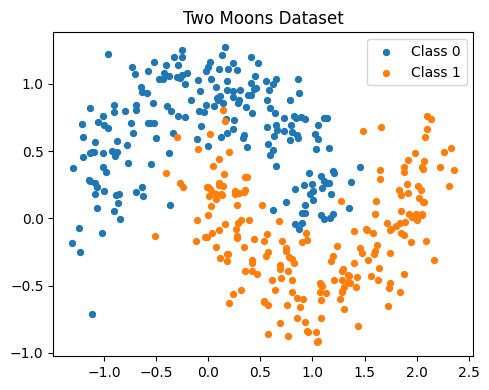

In [53]:
def make_moons_np(n_samples=500, noise=0.2, random_state=42):
    """NumPy fallback for two-moons."""
    rng = np.random.default_rng(random_state)
    m = n_samples // 2
    angles = rng.uniform(0, np.pi, size=m)

    x1 = np.c_[np.cos(angles), np.sin(angles)]
    x2 = np.c_[1 - np.cos(angles), -np.sin(angles) - 0.5]

    X = np.vstack([x1, x2])
    y = np.r_[np.zeros(m, dtype=int), np.ones(m, dtype=int)].reshape(-1, 1)
    X += rng.normal(scale=noise, size=X.shape)
    return X, y

def load_two_moons(n_samples=400, noise=0.2, random_state=42):
    try:
        from sklearn.datasets import make_moons
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
        return X, y.reshape(-1, 1)
    except Exception:
        return make_moons_np(n_samples=n_samples, noise=noise, random_state=random_state)

def plot_dataset(X, y):
    plt.figure(figsize=(5,4))
    plt.scatter(X[y[:,0]==0,0], X[y[:,0]==0,1], s=18, label="Class 0")
    plt.scatter(X[y[:,0]==1,0], X[y[:,0]==1,1], s=18, label="Class 1")
    plt.title("Two Moons Dataset")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Generate & plot
X, y = load_two_moons(n_samples=400, noise=0.2, random_state=42)
plot_dataset(X, y)

# Shapes for the network (columns = samples)
X_T = X.T        # (2, m)
y_T = y.T      # (1, m)


## Train the DFNN

We use architecture **2 → 20 → 10 → 1** with activations **[ReLU, ReLU, Sigmoid]**.  
Hyper-parameters can be tuned (epochs, learning rate).


In [54]:
layer_dims = [2, 20, 10, 1]
activation_funcs = ['relu', 'relu', 'sigmoid']
model = DeepNeuralNetwork(layer_dims, activation_funcs)

losses = model.train(X_T, y_T, epochs=5000, learning_rate=0.1, print_every=200)

# Training accuracy
y_pred = model.predict(X_T)                 # (1, m)
train_acc = np.mean((y_pred == y_T).astype(float))
print(f"Training Accuracy: {train_acc*100:.2f}%")


Epoch  200 | Loss: 0.2714
Epoch  400 | Loss: 0.2344
Epoch  600 | Loss: 0.1863
Epoch  800 | Loss: 0.1266
Epoch 1000 | Loss: 0.0935
Epoch 1200 | Loss: 0.0804
Epoch 1400 | Loss: 0.0733
Epoch 1600 | Loss: 0.0691
Epoch 1800 | Loss: 0.0664
Epoch 2000 | Loss: 0.0644
Epoch 2200 | Loss: 0.0622
Epoch 2400 | Loss: 0.0610
Epoch 2600 | Loss: 0.0601
Epoch 2800 | Loss: 0.0593
Epoch 3000 | Loss: 0.0587
Epoch 3200 | Loss: 0.0582
Epoch 3400 | Loss: 0.0577
Epoch 3600 | Loss: 0.0573
Epoch 3800 | Loss: 0.0569
Epoch 4000 | Loss: 0.0566
Epoch 4200 | Loss: 0.0562
Epoch 4400 | Loss: 0.0560
Epoch 4600 | Loss: 0.0557
Epoch 4800 | Loss: 0.0554
Epoch 5000 | Loss: 0.0552
Training Accuracy: 97.25%


## Training Loss over Epochs


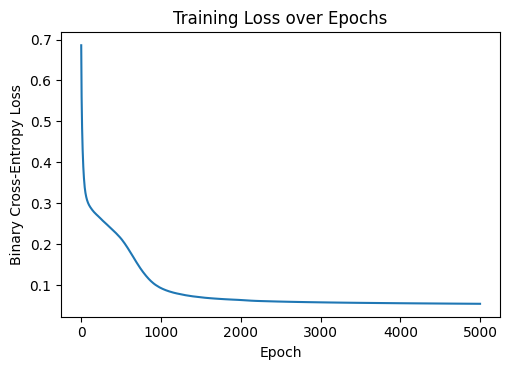

In [55]:
plt.figure(figsize=(5.2,3.8))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss over Epochs")
plt.tight_layout()
plt.show()


## Decision Boundary Visualization

We evaluate the trained model over a dense grid and plot the predicted regions, then overlay the original data points.


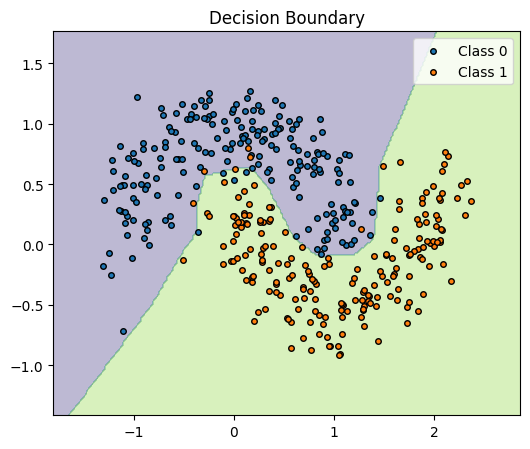

In [56]:
def plot_decision_boundary(model, X, y, h=0.02):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]             # (N, 2)
    preds = model.predict(grid.T).reshape(xx.shape)  # model expects (2, N)

    plt.figure(figsize=(5.4,4.6))
    plt.contourf(xx, yy, preds, alpha=0.35, levels=2)
    plt.scatter(X[y[:,0]==0,0], X[y[:,0]==0,1], s=16, label="Class 0", edgecolor="k")
    plt.scatter(X[y[:,0]==1,0], X[y[:,0]==1,1], s=16, label="Class 1", edgecolor="k")
    plt.title("Decision Boundary")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_decision_boundary(model, X, y)


## Discussion

- **Performance:** The DFNN typically separates the two moons well; confirm via training accuracy and the boundary plot.
- **Loss Curve:** Should generally decrease across epochs; plateaus/oscillations suggest tuning `learning_rate` or training longer.
- **Activations & Init:** ReLU + **He** init stabilizes deeper layers; **Sigmoid** on output provides probabilities for **BCE**.
- **Challenges:** Gradient flow (vanishing/exploding) mitigated by good init; sensitivity to LR; model capacity vs. overfitting trade-off.
